<a href="https://colab.research.google.com/github/djdongjin/IFT6135-Assignment/blob/master/A11_submitted_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1

**Team member** (alphabetical order):

Jin Dong, Liheng Ma, Maximilien Le Clei

Github link: https://github.com/djdongjin/IFT6135-Assignment

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(1)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

## 1. Building the Model

1st layer :
- Size: **784 x 666** 
- Number of parameters : (784 + 1) x 666 ⇔ 522.810
- Input : m x 784
- Output : m x 666

2nd layer (fc2) :
- Size: ** 666x666** 
- Number of parameters : (666 + 1) x 666 ⇔ 444.222
- Input : m x 666
- Output : m x 666

3rd layer (fc3) :
- Size: ** 666x10** 
- Number of parameters : (666 + 1) x 10 ⇔ 6.670
- Input : m x 500
- Output : m x 10

Total number of parameters : 973,702 which is in the range \[0.5M, 1.0M\]

In [0]:
def one_hot(labels, n):
    """labels: m*1 vector
       n: expected classes
       outout: m*n matrix"""
    m = len(labels)
    onehot = np.zeros((m, n))
    onehot[np.arange(m), labels] = 1
    return onehot

# We re-store the dataset into different npy files
# label is one-hot encoded by one_hot
DATA_PATH = r'/content/gdrive/My Drive/Datasets/MNIST'
X_train = np.load(DATA_PATH + '/x_train.npy')
y_train = one_hot(np.load(DATA_PATH + '/y_train.npy'),10)
X_val   = np.load(DATA_PATH + '/x_val.npy')
y_val   = one_hot(np.load(DATA_PATH + '/y_val.npy'),10)
X_test  = np.load(DATA_PATH + '/x_test.npy')
y_test  = one_hot(np.load(DATA_PATH + '/y_test.npy'),10)

In [0]:
def accuracy(y_pred, y):
    return np.sum(1 * np.argmax(y_pred, axis=1) \
                  == np.argmax(y, axis=1)) * 100.0 / y.shape[0]

def data_iter(data, batch_size):
    X, y = data
    batches = [(X[i:i+batch_size],y[i:i+batch_size]) \
               for i in range(0,X.shape[0],batch_size)]
    random.shuffle(batches)
    for batch in batches:
        yield batch
        
def glorot(in_dim, out_dim):
    d = np.sqrt(6/(in_dim+out_dim))
    return np.random.uniform(-d,d,(in_dim,out_dim))

In [0]:
INPUT_DIM = 784
OUTPUT_DIM = 10

class NN(object):
    
    def __init__(self,hidden_dims=[666,666], n_hidden=2, 
                 init='Normal',activate='relu'):
        self.dims = [INPUT_DIM,] + hidden_dims + [OUTPUT_DIM,]
        self.weights = []
        self.biases  = []
        self.init = init
        self.activate = activate
        
        self.initialize_weights()
        
    def initialize_weights(self):
        '''
        init weights of all layers according to self.init
        '''
        init_method = None
        if self.init == 'Zero':
            init_method = lambda x, y: np.zeros((x,y))
        elif self.init == 'Normal':
            init_method = lambda x, y: np.random.randn(x,y)
        elif self.init == 'Glorot':
            init_method = glorot
        else:
            raise Exception('Choose right initialization method.')
            
        for (inputs, outputs) in zip(self.dims[:-1], self.dims[1:]):
            self.weights.append(init_method(inputs, outputs))
            self.biases.append(np.zeros(outputs))
            
    def activation(self, inputs):
        if self.activate == 'relu':
            inputs[inputs < 0] = 0
            return inputs
        if self.activate == 'sigmoid':
            return 1.0/(1.0+np.exp(-inputs))
        
    def loss(self, pred, labels):
        '''
        cross entropy loss
        '''
        ls = np.nan_to_num(np.log(pred+1e-8))
        ls = - np.sum(labels * ls)
        return ls / pred.shape[0]
        
    def forward(self, inputs, labels):
        a_k = None
        h_k = inputs
        a   = []
        h   = [h_k]
        for (W, b) in zip(self.weights[:-1], self.biases[:-1]):
            a_k = np.dot(h_k, W) + b
            h_k = self.activation(a_k)
            a.append(a_k)
            h.append(h_k)
        
        a_k = np.dot(h_k, self.weights[-1]) + self.biases[-1]
        h_k = self.softmax(a_k)
        a.append(a_k)
        h.append(h_k)
        
        ls = self.loss(h_k, labels)
        cache = (a, h)
        
        return h_k, ls, cache
    
    def backward(self,cache,labels,lss):
        """
        Input: cache: (as, hs)
                    as: preactivate values
                    hs: activated values
                    lss: loss
        output: grads: (grads_w, grads_b)
        """
        as_ = cache[0]
        hs_ = cache[1]
        
        nabla_w = [np.zeros_like(w) for w in self.weights]
        nabla_b = [np.zeros_like(b) for b in self.biases]

        # nabla l -> softmax -> pre-softmax
        nabla_a = -(labels - hs_[-1])
        nabla_b[-1] = np.sum(nabla_a, axis=0)
        nabla_w[-1] = np.dot(hs_[-2].T, nabla_a)
        # for each preactivate -> activation layer
        for layer in range(2, len(self.dims)):
            nabla_h = np.dot(nabla_a, self.weights[-layer+1].T)
            nabla_a = nabla_h * self.activate_grad(as_[-layer])

            nabla_b[-layer] = np.sum(nabla_a, axis=0)
            nabla_w[-layer] = np.dot(hs_[-layer-1].T, nabla_a)

        nabla_w = [x / labels.shape[0] for x in nabla_w]
        nabla_b = [x / labels.shape[0] for x in nabla_b]
        return (nabla_w,nabla_b)
   
    def update(self,grads,lr):
        grads_w, grads_b = grads
        for i in range(len(self.weights)):
            self.weights[i] -= lr * grads_w[i]
            self.biases[i] -= lr * grads_b[i]

    def train(self, data, epochs, batch_size, lr, lambd=0.0, test_data=None):
        l_acc = []
        l_ls  = []
        for ep in range(1, epochs+1):
            for (batch_x, batch_y) in data_iter(data, batch_size):
                y_pred, ls, cache = self.forward(batch_x, batch_y)
                grads = self.backward(cache, batch_y, ls)
                self.update(grads, lr)
            if test_data:
                acc, ls = self.test(test_data)
                l_acc.append(acc)
                l_ls.append(ls)
                print('Epoch %i (acc, loss):(%.4f,%.4f)' % (ep, acc, ls))
        return l_acc, l_ls
                
    def test(self, data):
        x, y = data
        outputs, ls, _ = self.forward(x, y)
        return accuracy(outputs, y), ls
    
    def activate_grad(self,inputs):
        '''
        derivatives of activation function
        '''
        if self.activate == 'relu':
            inputs[inputs > 0] = 1
            inputs[inputs < 0] = 0
            return inputs
        elif self.activate == 'sigmiod':
            return self.activation(inputs) * (1 - self.activation(inputs))
        
    def softmax(self,inputs):
        inputs = inputs - np.max(inputs, axis=1).reshape(inputs.shape[0],1)
        outputs = np.exp(inputs)
        return outputs / (np.sum(outputs, axis=1).reshape(inputs.shape[0],1))
        

## 2. Initialization

The results show that:

1. Networks with zero initialization learn nothing. Becasuse corresponding weights, intermediate variables are also zeros, and will be used to compute gradients, most gradients will be also zero which causes the network learns nothing.

2. Networks with normal initialization need smaller learning rate. We tried to use a large learning rate but the loss went to infinity. The reason is that if we use a large learning rate and the network was initialized to a bad point. Some of the predicted probabilites of the right classes will be close to 0, causing the cross entropy loss moves to infinity.

3. Networks with Glorot initialization are more stable when we use relatively large learning rate., and it has the lowest loss. Later we tried to use a large learning rate and it indeed achieved a higher accuracy and lower loss.

We use the architecture as below in this section:

1. Architecture (dimensions) : 784 -> 666 -> 666 -> 10.
2. parameters:  785\*666+667\*666+667\*10 = 973,702 parameters.
3. Nonlinearity : ReLU
4. Learning rate : 0.001(zero init), 0.001(normal init), 0.001(glorot init)
5. Batch size : 200
6. Numpy random seed : 0
7. Epochs: 10

Epoch 1 (acc, loss):(11.3560,2.3025)
Epoch 2 (acc, loss):(11.3560,2.3024)
Epoch 3 (acc, loss):(11.3560,2.3024)
Epoch 4 (acc, loss):(11.3560,2.3023)
Epoch 5 (acc, loss):(11.3560,2.3022)
Epoch 6 (acc, loss):(11.3560,2.3022)
Epoch 7 (acc, loss):(11.3560,2.3021)
Epoch 8 (acc, loss):(11.3560,2.3021)
Epoch 9 (acc, loss):(11.3560,2.3020)
Epoch 10 (acc, loss):(11.3560,2.3020)
Epoch 1 (acc, loss):(83.5200,3.0166)
Epoch 2 (acc, loss):(86.9920,2.3763)
Epoch 3 (acc, loss):(89.2580,1.9582)
Epoch 4 (acc, loss):(90.5040,1.7294)
Epoch 5 (acc, loss):(91.2940,1.5834)
Epoch 6 (acc, loss):(92.0040,1.4537)
Epoch 7 (acc, loss):(92.1200,1.4337)
Epoch 8 (acc, loss):(92.7720,1.3127)
Epoch 9 (acc, loss):(93.4780,1.1762)
Epoch 10 (acc, loss):(93.8880,1.1055)
Epoch 1 (acc, loss):(47.3440,2.0974)
Epoch 2 (acc, loss):(62.4400,1.9122)
Epoch 3 (acc, loss):(68.2780,1.7282)
Epoch 4 (acc, loss):(72.7720,1.5485)
Epoch 5 (acc, loss):(75.5820,1.3807)
Epoch 6 (acc, loss):(77.9220,1.2317)
Epoch 7 (acc, loss):(79.5380,1.1046)

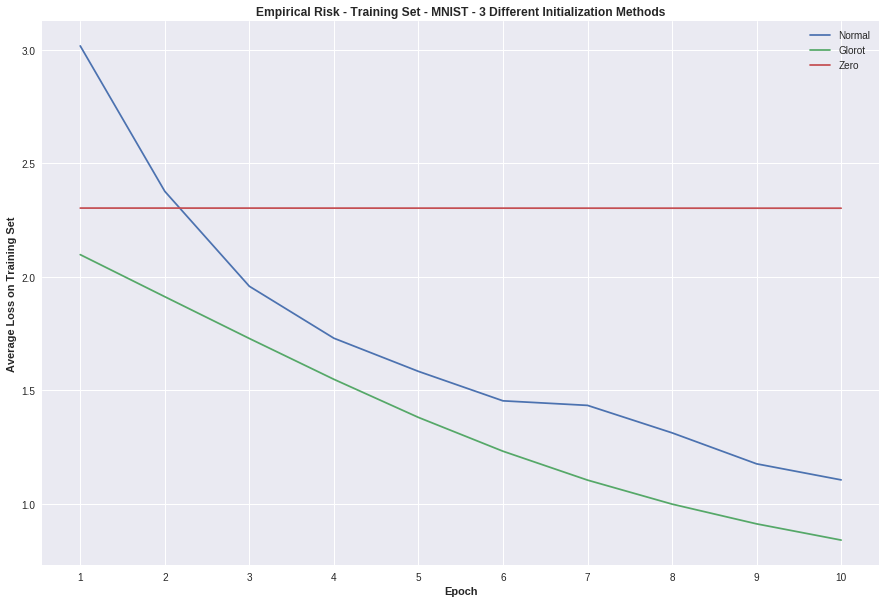

In [0]:
nn1 = NN(hidden_dims=[666,666],n_hidden=2,init='Zero')
zero_acc, zero_ls = nn1.train((X_train,y_train), epochs=10, batch_size=200, 
                              lr=0.001, test_data=(X_train,y_train))

nn2 = NN(hidden_dims=[666,666],n_hidden=2,init='Normal')
normal_acc, normal_ls = nn2.train((X_train,y_train), epochs=10, batch_size=200, 
                                  lr=0.001, test_data=(X_train,y_train))

nn3 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
glorot_acc, glorot_ls = nn3.train((X_train,y_train), epochs=10, batch_size=200, 
                                  lr=0.001, test_data=(X_train,y_train))

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

plt.xticks(np.arange(0, 11, step=1))
plt.xlabel('Epoch', weight='bold')
plt.ylabel('Average Loss on Training Set', weight='bold')
tlt = 'Empirical Risk - Training Set - MNIST - 3 Different Initialization Methods'
plt.title(tlt, weight='bold')

plt.plot(np.arange(1, 11, step=1), normal_ls, label='Normal')
plt.plot(np.arange(1, 11, step=1), glorot_ls, label='Glorot')
plt.plot(np.arange(1, 11, step=1), zero_ls, label='Zero')
plt.legend()
plt.show()

## 3. Hyperparameter Search

We achieved more than 97% accuracy on validation dataset by using below hyperparameters 

1. Architecture (dimensions) : 784 -> 666 -> 666 -> 10.
2. parameters:  785\*666+667\*666+667\*10 = 973,702 parameters.
3. Nonlinearity : ReLU
4. Learning rate : 0.1
5. Batch size : 100
6. Numpy random seed : 0
7. Initialization : Glorot
8. Epochs: 10



In [0]:
nn4 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
best_acc, best_ls = nn4.train((X_train,y_train), epochs=10, batch_size=100, 
                              lr=0.1, test_data=(X_val,y_val))

Epoch 1 (acc, loss):(93.5900,0.2212)
Epoch 2 (acc, loss):(95.7800,0.1518)
Epoch 3 (acc, loss):(96.7000,0.1251)
Epoch 4 (acc, loss):(96.6000,0.1179)
Epoch 5 (acc, loss):(97.1600,0.0952)
Epoch 6 (acc, loss):(97.6300,0.0848)
Epoch 7 (acc, loss):(97.6000,0.0840)
Epoch 8 (acc, loss):(97.5800,0.0820)
Epoch 9 (acc, loss):(97.8000,0.0770)
Epoch 10 (acc, loss):(97.8600,0.0730)


**Other hyperparameters we tried**

We also tried hyperparameters as below, as well as corresponding accuracy on validation set:

- Learning rate: 0.001 -> 82.89%; 0.01 -> 94.48%
- Batch size: 256 -> 92.37% ; 512 -> 91.07%
- Epochs: 15 -> 95.50%; 20 -> 96.11%
- Hidden size: (1024, 512) -> 97.94%

In [0]:
# lr 0.01
nn4 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
best_acc, best_ls = nn4.train((X_train,y_train), epochs=10, batch_size=100, 
                              lr=0.01, test_data=(X_val,y_val))

Epoch 1 (acc, loss):(88.6400,0.4796)
Epoch 2 (acc, loss):(90.9100,0.3447)
Epoch 3 (acc, loss):(91.5800,0.3017)
Epoch 4 (acc, loss):(92.2800,0.2765)
Epoch 5 (acc, loss):(92.5700,0.2592)
Epoch 6 (acc, loss):(93.0500,0.2414)
Epoch 7 (acc, loss):(93.3800,0.2295)
Epoch 8 (acc, loss):(93.6300,0.2207)
Epoch 9 (acc, loss):(94.0700,0.2077)
Epoch 10 (acc, loss):(94.4800,0.1996)


In [0]:
# batch size 256
nn4 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
best_acc, best_ls = nn4.train((X_train,y_train), epochs=10, batch_size=256, 
                              lr=0.01, test_data=(X_val,y_val))

Epoch 1 (acc, loss):(82.5700,0.9967)
Epoch 2 (acc, loss):(87.9900,0.5628)
Epoch 3 (acc, loss):(89.4800,0.4367)
Epoch 4 (acc, loss):(90.2500,0.3792)
Epoch 5 (acc, loss):(90.9900,0.3468)
Epoch 6 (acc, loss):(91.4100,0.3242)
Epoch 7 (acc, loss):(91.6000,0.3094)
Epoch 8 (acc, loss):(91.9500,0.2950)
Epoch 9 (acc, loss):(92.2500,0.2845)
Epoch 10 (acc, loss):(92.3700,0.2760)


In [0]:
# batch size 512
nn4 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
best_acc, best_ls = nn4.train((X_train,y_train), epochs=10, batch_size=512, 
                              lr=0.01, test_data=(X_val,y_val))

Epoch 1 (acc, loss):(76.6000,1.5642)
Epoch 2 (acc, loss):(83.7900,0.9759)
Epoch 3 (acc, loss):(86.6000,0.6921)
Epoch 4 (acc, loss):(88.2700,0.5559)
Epoch 5 (acc, loss):(89.2400,0.4797)
Epoch 6 (acc, loss):(89.7500,0.4321)
Epoch 7 (acc, loss):(90.1100,0.3995)
Epoch 8 (acc, loss):(90.6100,0.3748)
Epoch 9 (acc, loss):(90.8500,0.3570)
Epoch 10 (acc, loss):(91.0700,0.3426)


In [0]:
nn4 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
best_acc, best_ls = nn4.train((X_train,y_train), epochs=20, batch_size=100, 
                              lr=0.01, test_data=(X_val,y_val))

Epoch 1 (acc, loss):(88.4400,0.4835)
Epoch 2 (acc, loss):(90.3400,0.3499)
Epoch 3 (acc, loss):(91.4100,0.3051)
Epoch 4 (acc, loss):(91.8500,0.2826)
Epoch 5 (acc, loss):(92.4700,0.2624)
Epoch 6 (acc, loss):(93.0400,0.2448)
Epoch 7 (acc, loss):(93.4100,0.2304)
Epoch 8 (acc, loss):(93.9400,0.2188)
Epoch 9 (acc, loss):(94.2200,0.2092)
Epoch 10 (acc, loss):(94.4200,0.2008)
Epoch 11 (acc, loss):(94.6600,0.1934)
Epoch 12 (acc, loss):(95.0800,0.1843)
Epoch 13 (acc, loss):(95.3700,0.1777)
Epoch 14 (acc, loss):(95.4400,0.1721)
Epoch 15 (acc, loss):(95.5000,0.1668)
Epoch 16 (acc, loss):(95.7200,0.1623)
Epoch 17 (acc, loss):(95.7800,0.1567)
Epoch 18 (acc, loss):(96.0500,0.1512)
Epoch 19 (acc, loss):(96.1100,0.1473)
Epoch 20 (acc, loss):(96.1100,0.1438)


In [0]:
nn4 = NN(hidden_dims=[1024,512],n_hidden=2,init='Glorot')
best_acc, best_ls = nn4.train((X_train,y_train), epochs=10, batch_size=100, 
                              lr=0.1, test_data=(X_val,y_val))

Epoch 1 (acc, loss):(94.6200,0.1955)
Epoch 2 (acc, loss):(95.9300,0.1420)
Epoch 3 (acc, loss):(96.5700,0.1176)
Epoch 4 (acc, loss):(96.9800,0.0993)
Epoch 5 (acc, loss):(97.4500,0.0903)
Epoch 6 (acc, loss):(97.5700,0.0849)
Epoch 7 (acc, loss):(97.5700,0.0831)
Epoch 8 (acc, loss):(97.9100,0.0720)
Epoch 9 (acc, loss):(97.9400,0.0681)
Epoch 10 (acc, loss):(97.9400,0.0715)


## 4. Validate Gradients using Finite Diﬀerence

We tried 10 N values (1, 5, 10, 50, 1000, 5000, 100000, 500000).  The diagram show that, with N increasing ($\epsilon$ decreasing), the difference between the finite difference gradient approximation and gradient obtained from back propagation is becoming smaller till 0, which means the finite difference gradient approximation is becoming more accurate, till close to the real gradient.

We also fount sometimes the result was a horizon line, which means no differences at all. By checking the input data, we found the reason is that the corresponding pixel value of  that weight is zero, which means there is no gradients at these weights if we input that image.

N values used: [1, 5, 10, 50, 1000, 5000, 100000, 500000]


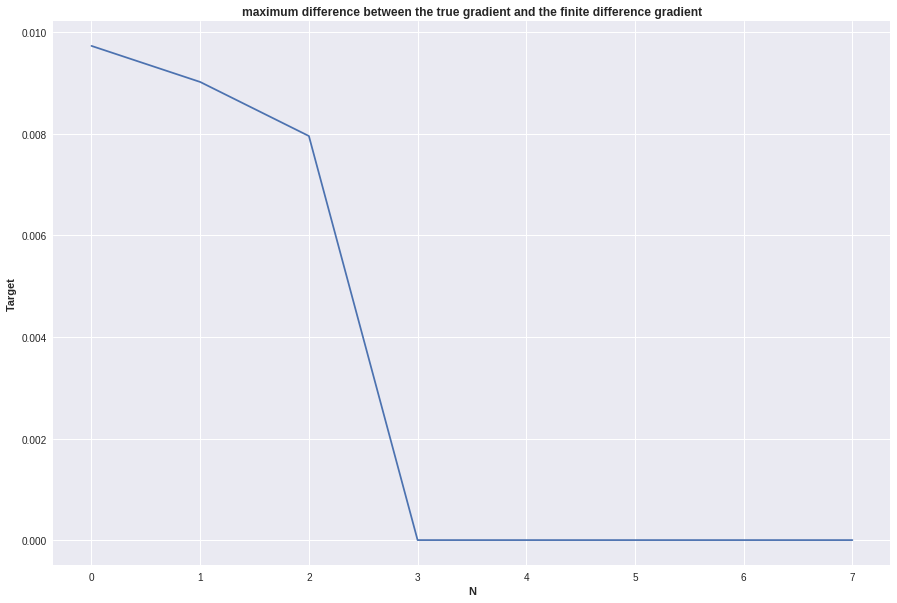

In [0]:
nn5 = NN(hidden_dims=[666,666],n_hidden=2,init='Glorot')
i_value = [0,1,3,5]
k_value = [1,5]
N_value = [k*10**i for i in i_value for k in k_value]
print('N values used:', N_value)
p = 10

# obtain one data point, fix random.seed to reproduce the result.
np.random.seed(100)
data_number = np.random.randint(0,X_train.shape[0])
X, y = X_train[data_number,:].reshape(1,-1), y_train[data_number,:].reshape(1,-1)

# compute forward and backward prop and the gradient
y_hat, ls, cache = nn5.forward(X, y)
grad_W, grad_b = nn5.backward(cache, y, ls)
# Use the second layer to validate gradient.
grad_theta = grad_W[1][:p,0]

res = []
for N in N_value:
    epsilon = 1 / N
    grad_diff = np.zeros(p)
    for i in range(p):
        # compute L(+epsilon)
        nn5.weights[1][i,0] += epsilon
        _, L_plus, _ = nn5.forward(X,y)
        # compute L(-epsilon)
        nn5.weights[1][i,0] -= 2*epsilon
        _, L_minus,_ = nn5.forward(X,y)
        # recover weight
        nn5.weights[1][i,0] += epsilon
        # Finite Difference
        grad_diff[i] = (L_plus/epsilon-L_minus/epsilon) / 2
    res.append(np.max(np.abs(grad_theta - grad_diff)))
    
plt.xlabel('N', weight='bold')
plt.ylabel('Target', weight='bold')
plt.title('maximum difference between the true gradient and the ﬁnite difference gradient', weight='bold')
plt.plot(np.arange(len(res)), res)    

where x=(0, 1, 2, 3, ,4 ,5, 6, 7) corresponds to N= (1, 5, 10, 50, 1000, 5000, 100000, 500000), respectively.